# Continuous Control

### 1. Start the Environment

We begin by importing the necessary packages. 

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import copy
from collections import namedtuple, deque
%matplotlib inline

Next, we will start the environment, where two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1. If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01. Thus, the goal of each agent is to keep the ball in play.

In [2]:
env = UnityEnvironment(file_name="D:\Programs\projects\deep-reinforcement-learning\Multi-Agent RL\p3_collab-compet\Tennis_Windows_x86_64\Tennis_Windows_x86_64\Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


**_Brains_** are responsible for deciding the actions of their associated agents in the environment. We can set the first brain available as the default brain that controls the rackets.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The observation space consists of `24` variables corresponding to position and velocity of the ball and rackets.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. The action space should be between -1.0 and +1.0.

Some information about the environment can be obtained by running the code below.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])


Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Code Cells

#### Parameters

In [5]:
BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 256        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-4         # learning rate of the actor 
LR_CRITIC = 3e-4        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay for Adam Optimizer
UPDATE_INTERVAL = 25    # Number of episodes elapsed between updates
UPDATE_FREQUENCY = 4    # Number of times parameters and policy will be updated from a sample of experiences in each update
UPDATE_STEP = 0         # Step counter for update (update begins when it hits 0 again after UPDATE_INTERVAL steps)
RANDOM_SEED = 10
NOISE_REDUCTION_FACTOR =0.99999
NOISE_MULTIPLIER = 1.0
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#### Agent

In [6]:
class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, random_seed, critic_local, critic_target, critic_optimizer, memory):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)
        self.update_step = UPDATE_STEP

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = critic_local
        self.critic_target = critic_target
        self.critic_optimizer = critic_optimizer

        # Noise process
        self.noise = OUNoise(action_size, random_seed)
        self.noise_multiplier = NOISE_MULTIPLIER

        # Replay memory
        self.memory = memory
    
    def step(self, state, action, reward, next_state, done):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        self.memory.add(state, action, reward, next_state, done)
        # the following line is added so update interval can be adjusted
        self.update_step = (self.update_step + 1) % UPDATE_INTERVAL
        # Learn, if enough samples are available in memory
        if len(self.memory) > BATCH_SIZE:
            if self.update_step == 0:
                #update multiple times after certain number of steps
                for i in range(UPDATE_FREQUENCY):
                    experiences = self.memory.sample()
                    self.learn(experiences, GAMMA)

    def act(self, state, add_noise=True, gaussian=False):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            if not gaussian:
                action += self.noise.sample()*self.noise_multiplier 
                self.noise_multiplier = self.noise_multiplier * NOISE_REDUCTION_FACTOR
            else:
                action += np.random.normal()*self.noise_multiplier
                self.noise_multiplier = self.noise_multiplier * NOISE_REDUCTION_FACTOR
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)
    

#### Model

In [7]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc_units=256):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc_units)
        self.fc2 = nn.Linear(fc_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.relu(self.fc1(state))
        return torch.tanh(self.fc2(x))

class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fcs1_units=256, fc2_units=256, fc3_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, fc3_units)
        self.fc4 = nn.Linear(fc3_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(*hidden_init(self.fc3))
        self.fc4.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.leaky_relu(self.fcs1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        return self.fc4(x) 

### 4. Main Program

In [8]:
critic_local  = Critic(state_size, action_size, RANDOM_SEED).to(device)
critic_target = Critic(state_size, action_size, RANDOM_SEED).to(device)
critic_optimizer = optim.Adam(critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)
memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, RANDOM_SEED)
agent0 = Agent(state_size, action_size, RANDOM_SEED, critic_local, critic_target, critic_optimizer, memory)
agent1 = Agent(state_size, action_size, RANDOM_SEED, critic_local, critic_target, critic_optimizer, memory)
def ddpg(n_episodes=4500, max_t=2000, print_every=500):

    scores_deque= deque(maxlen = 100)
    scores=[]
    average_scores =[]
    max_average_score= -np.Inf
    is_max_winner0 = None
    first_solution = None
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        score0 = 0                      # initialize the score 
        score1 = 0
        agent0.reset()
        agent1.reset()
        for t in range(max_t):
            action0 = agent0.act(states[0], True, True)            # add noise?(Bool), Gaussian?(Bool)
            action1 = agent1.act(states[1], True, True)
            actions = [action0, action1]
            env_info = env.step(actions)[brain_name]          # send all actions to tne environment
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            agent0.step(states[0], actions[0], rewards[0], next_states[0], dones[0])
            agent1.step(states[1], actions[1], rewards[1], next_states[1], dones[1])
            states = next_states
            score0 += rewards[0]
            score1 += rewards[1]
            if dones[0] or dones[1]:
                break 
        if score0 > score1:
            final_score = score0
            winner0 = True 
            agent = agent0
        else:
            final_score = score1
            winner0 = False
            agent = agent1
        scores_deque.append(final_score)
        scores.append(final_score)     
        average_scores.append(np.mean(scores_deque))
        if i_episode % print_every == 0:
            print('\n\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        #solution found if average score over 100 episode is at least 0.5
        if np.mean(scores_deque) >= 0.5 and i_episode >= 100:
            if first_solution == None:
                first_solution = i_episode
                print ("First solution found in Episode: ", i_episode)
            #record solution if it is the best so far
            if np.mean(scores_deque)> max_average_score:
                max_average_score = np.mean(scores_deque)
                is_max_winner0 = winner0
                print ('\rBest solution found in Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)), end="")
                torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
                torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
                # early stop
                if max_average_score > 2.5:
                    return scores, average_scores, is_max_winner0
    if is_max_winner0 == None:
        print ('\n\rProblem not solved in Episode {} \tMax Average Score: {:.2f}'.format(n_episodes, max(average_scores)))
    return scores, average_scores, is_max_winner0

scores, average_scores, is_max_winner0 = ddpg()



Episode 500	Average Score: 0.03

Episode 1000	Average Score: 0.02

Episode 1500	Average Score: 0.00

Episode 2000	Average Score: 0.00

Episode 2500	Average Score: 0.02

Episode 3000	Average Score: 0.07

Episode 3500	Average Score: 0.11

Episode 4000	Average Score: 0.14
First solution found in Episode:  4087
Best solution found in Episode 4386	Average Score: 2.50

### 5. Result and Visual Presentation

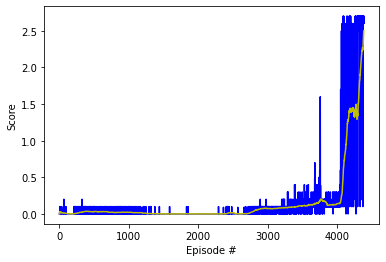

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
line = np.arange(1, len(scores)+1)
plt.plot(line, scores, 'b-', line , average_scores, 'y-')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()


In [12]:
if is_max_winner0 != None:
    if is_max_winner0 == True:
        agent = agent0
    else:
        agent = agent1
    agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
    agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))
    for i in range(3):
        env_info = env.reset(train_mode=False)[brain_name]
        states = env_info.vector_observations
        points = np.zeros(num_agents)
        for j in range(5000):
            action0 = agent.act(states[0], False, True)           
            action1 = agent.act(states[1], False, True)            
            actions = [action0, action1]
            env_info = env.step(actions)[brain_name]          
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            points += rewards
            states = next_states
            if np.any(dones):
                break 
        print('Score (max over agents) from episode {}: {}'.format(i, np.max(points)))

Score (max over agents) from episode 0: 2.600000038743019
Score (max over agents) from episode 1: 2.600000038743019
Score (max over agents) from episode 2: 2.7000000402331352


When finished, you can close the environment.

In [13]:
env.close()

### 6. Discussion

It uses a Deep Deterministic Policy Gradient (DDPG) approach, which involves an actor network and a critic network. 

The “Critic” estimates the value function. This could be the action-value (the Q value) or state-value (the V value). The “Actor” updates the policy distribution in the direction suggested by the Critic (such as with policy gradients). Both the Critic and Actor functions are parameterized with neural networks. 

To foster collaboration between agents, a few modifications are made to the regular DDPG approach:

1.) Shared replay buffer - both agents contribute to the experiences of the buffer and can sample from it.

2.) Shared Critic - both agents are initialized with the same Critic which provides a common baseline.

3.) Shared information of states - each agent has access to states of the ball and the opponent, but from it's own point of view.

I experimented with update interval and frequency, which is the number of replay examples used in each update. The current configuration seems to generate the best results. Basically, I want to do a number of updates each time after a certain number of episodes. These variables also seem to affect the results the most in the second project.

Both actor and critic neural networks consist of multiple linear layers. Their structures mirror those in the Bipedal and Pendulum examples in the class's Github repository. 

For future improvement, I will try adding noise to the parameters as well, which can lead to more consistent exploration and a richer set of behaviors (arXiv:1706.01905 [cs.LG]). I will also try priority experience replay: replaying important    transitions more frequently can help agent learn more efficiently (arXiv:1511.05952v4 [cs.LG]). 